In [1090]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
sys.path.append("/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/hl2ss/viewer")
%matplotlib inline

In [1091]:
from mpl_toolkits import mplot3d
import json
import hl2ss
import hl2ss_3dcv

In [1092]:
from PoseVisualizer import CameraPoseVisualizer

# Phase Unwrap Projection Visualization

### Setup Code

In [1093]:
#code to load up poses
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/raw-04-13-13-55/'

with open(PATH+'vlc1_pose.json') as f: # vlc LF
    j_vlc_lf = json.load(f)
with open(PATH+'vlc3_pose.json') as f:
    j_vlc_rf = json.load(f)
with open(PATH+'depth_ahat_pose.json') as f: # long throw
    j_ahat = json.load(f)
    
tstamps = sorted(j_ahat.keys())

def get_im(tstamp, root_path):
    return cv2.imread(root_path+tstamp+'.png')

def get_posed_data(idx, sensor_name, pose_name):
    tstamp_name = tstamps[idx]
    im = cv2.imread(PATH+sensor_name+'/'+tstamp_name+'.png')
    pose = pose_name[tstamp_name]
    return im, pose

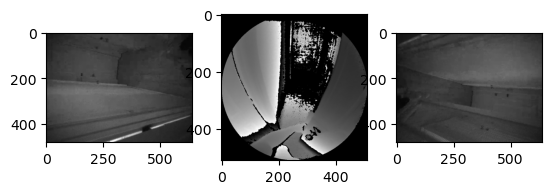

In [1094]:
#display code to see what we see throughout time

im, pose = get_posed_data(100,'vlc_lf',j_vlc_lf)
im1, pose1 = get_posed_data(100,'depth_ahat',j_ahat)
im2, pose2 = get_posed_data(100,'vlc_rf',j_ahat)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(im)
axs[1].imshow(im1)
axs[2].imshow(im2)

In [1095]:
def get_unwrap_set(idx):
    im, pose = get_posed_data(idx,'vlc_lf',j_vlc_lf)
    im1, pose1 = get_posed_data(idx,'depth_ahat',j_ahat)
    im2, pose2 = get_posed_data(idx,'vlc_rf',j_ahat)
    
    im = np.mean(im,axis=2)
    im1 = np.mean(im1,axis=2)
    im2 = np.mean(im2,axis=2)
    return im,pose,im1,pose1,im2,pose2

In [1096]:
CALIB_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/test/'
def get_all_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(CALIB_PATH+'calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(CALIB_PATH+'calibrations/rm_depth_longthrow')
    calib_ahat = hl2ss_3dcv._load_calibration_rm_depth_ahat(CALIB_PATH+'calibrations/rm_depth_ahat')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftfront')
    calib_rr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightright')
    calib_lr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftleft')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_ahat.intrinsics, hl2ss.Parameters_RM_DEPTH_AHAT.WIDTH, hl2ss.Parameters_RM_DEPTH_AHAT.HEIGHT)
    xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_ahat.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy1, scale

In [1097]:
calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy, scale = get_all_calibration()

In [1098]:
print(calib_lf.intrinsics.T)
print(calib_rf.intrinsics.T)
print(calib_ahat.intrinsics.T)

[[362.6172    0.      311.65042   0.     ]
 [  0.      357.87915 227.55858   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
[[362.57703   0.      332.9669    0.     ]
 [  0.      358.7988  239.92181   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
[[114.55879   0.      256.11627   0.     ]
 [  0.      114.85222 260.75302   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]


### dimensions
- im_lf.shape = (480,640)
- im_rf.shape = (480, 640)
- im_ahat.shape = (512, 512) 

In [1099]:
# #modifying the focal lengths
# f = (calib_lf.intrinsics[0,0] + calib_lf.intrinsics[1,1])/2
# calib_lf.intrinsics[0,0] = f
# calib_lf.intrinsics[1,1] = f

# f = (calib_rf.intrinsics[0,0] + calib_rf.intrinsics[1,1])/2
# calib_rf.intrinsics[0,0] = f
# calib_rf.intrinsics[1,1] = f

# f = (calib_ahat.intrinsics[0,0] + calib_ahat.intrinsics[1,1])/2
# calib_ahat.intrinsics[0,0] = f
# calib_ahat.intrinsics[1,1] = f
# #modifying the center camera coord
# calib_lf.intrinsics[2,:] = np.array([320,240,1,0])
# calib_rf.intrinsics[2,:] = np.array([320,240,1,0])
# calib_ahat.intrinsics[2,:] = np.array([256,256,1,0])

In [1100]:
print(calib_lf.intrinsics.T)
print(calib_rf.intrinsics.T)
print(calib_ahat.intrinsics.T)

[[362.6172    0.      311.65042   0.     ]
 [  0.      357.87915 227.55858   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
[[362.57703   0.      332.9669    0.     ]
 [  0.      358.7988  239.92181   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
[[114.55879   0.      256.11627   0.     ]
 [  0.      114.85222 260.75302   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]


## visualize extrinsics

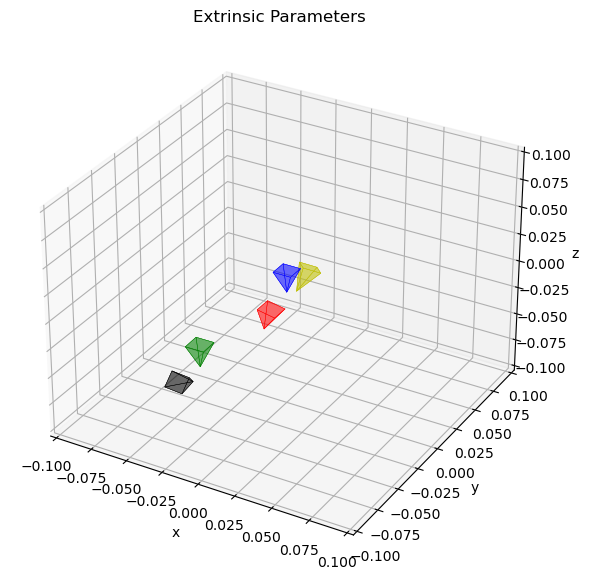

In [1101]:
scale = .1
visualizer = CameraPoseVisualizer([-scale, scale], [-scale, scale], [-scale, scale])

#extrinsic is 4x4
visualizer.extrinsic2pyramid(np.linalg.inv(calib_ahat.extrinsics).T, 'r', focal_len_scaled=0.02)

visualizer.extrinsic2pyramid(np.linalg.inv(calib_lf.extrinsics).T, 'b', focal_len_scaled=0.02)
visualizer.extrinsic2pyramid(np.linalg.inv(calib_lr.extrinsics).T, 'y', focal_len_scaled=0.02)

visualizer.extrinsic2pyramid(np.linalg.inv(calib_rf.extrinsics).T, 'g', focal_len_scaled=0.02)
visualizer.extrinsic2pyramid(np.linalg.inv(calib_rr.extrinsics).T, 'k', focal_len_scaled=0.02)
visualizer.show()

## visualize depth

In [1102]:
im_lf, pose_lf, im_ahat, pose_ahat, im_rf, pose_rf = get_unwrap_set(100)

In [1103]:
ahat_pts = (im_ahat[:,:,np.newaxis]/255) * xy

Rays shape: (512, 512, 3)


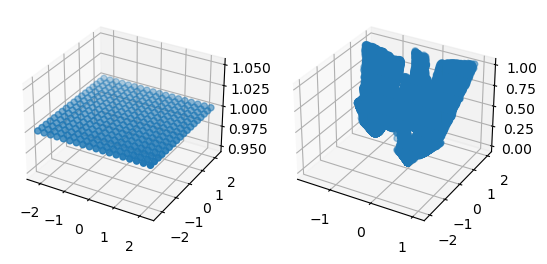

In [1104]:
print(f'Rays shape: {xy.shape}')
# ax = plt.axes(projection='3d')
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))

#visualize every other 10 to get the dots
axs[0].scatter3D(xy[::30,::30,0].flatten(),xy[::30,::30,1].flatten(),xy[::30,::30,2].flatten())
axs[1].scatter3D(ahat_pts[:,:,0].flatten(),ahat_pts[:,:,1].flatten(),ahat_pts[:,:,2].flatten())

In [1105]:
# uv = intrinsic @ extrinsic @ pt3
# 3d_pt = extrinsic @ pt3
# extrinsic^-1 @ 3d_pt = pt3
# other_uv = other_intrinsic @ other_extrinsic @ pt3
pts_3d = reshaped_pts
pt3 = np.append(pts_3d[:,40000],1).reshape(4,1)

other_uv_proj = (calib_lf.intrinsics.T @ calib_lf.extrinsics.T @ np.linalg.inv(calib_ahat.extrinsics).T @ pt3)
other_uv_proj = other_uv_proj[0:2,:] / other_uv_proj[2,:]
print(other_uv_proj)

[[  804.69517466]
 [-1289.67105618]]


In [1106]:
pts_3d = reshaped_pts
pts_3d = np.vstack((pts_3d, np.ones((1,pts_3d.shape[1]))))
uv_proj = (calib_lf.intrinsics.T @ calib_lf.extrinsics.T @ np.linalg.inv(calib_ahat.extrinsics).T @ pts_3d)
uv = uv_proj[0:2,:] / uv_proj[2,:]

print(uv[0,:].min())
print(uv[0,:].max())
print(uv[1,:].min())
print(uv[1,:].max())

-140.06562109057282
2127.478474784024
-1289.671056176759
1144.694758427019


In [1107]:
def get_uv_vlc(idx):
    im_lf, pose_lf, im_ahat, pose_ahat, im_rf, pose_rf = get_unwrap_set(idx)
    
    ahat_pts = ((im_ahat[:,:,np.newaxis]/255) * xy).reshape(3,1)
    return ahat_pts

def parse_pts(pts_3d):
    return pts_3d[:, pts_3d[2,:] > 0]
def get_uv(calib_other, calib_depth, pts_3d):
    '''
        Arguments:
        -----------
            pts3d: 3xN matrix
        
        Returns:
        --------
            uv: 2xN matrix returns as (x,y) or (col,row)
    '''
    pts_3d = np.vstack((pts_3d, np.ones((1,pts_3d.shape[1]))))
    uv_proj = (calib_other.intrinsics.T @ calib_other.extrinsics.T @ np.linalg.inv(calib_depth.extrinsics).T @ pts_3d)
    uv = uv_proj[0:2,:] / uv_proj[2,:]
    return uv

In [1108]:
#any z=0 means it didn't work out
parsed_pts = reshaped_pts[:, reshaped_pts[2,:] > 0 ]

In [1109]:
uv_lf = get_uv(calib_lf, calib_ahat, parsed_pts)
uv_rf = get_uv(calib_rf, calib_ahat, parsed_pts)

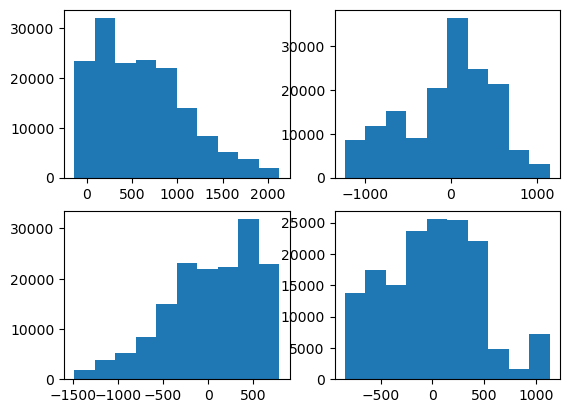

In [1110]:
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(uv_lf[0,:])
axs[0,1].hist(uv_lf[1,:])
axs[1,0].hist(uv_rf[0,:])
axs[1,1].hist(uv_rf[1,:])
plt.show()

### Strategy for efficient unwrapping

In [1111]:
parsed_pts * ((1 + parsed_pts[2,:]) / parsed_pts[2,:])

array([[ 0.18301193,  0.1917753 ,  0.20053868, ...,  1.23461687,
         1.2433802 ,  1.25214353],
       [-2.26175633, -2.26175633, -2.26175633, ...,  2.18740522,
         2.18740522,  2.18740522],
       [ 1.00392157,  1.00392157,  1.00392157, ...,  1.00392157,
         1.00392157,  1.00392157]])

In [1112]:
uv_lf = get_uv(calib_lf, calib_ahat, parsed_pts * ((1 + parsed_pts[2,:]) / parsed_pts[2,:]))

In [1113]:
def phase_unwrap(idx, max_integer=4):
    im_lf, pose_lf, im_ahat, pose_ahat, im_rf, pose_rf = get_unwrap_set(idx)
    ahat_pts = ((im_ahat/scale)[:,:,np.newaxis] * xy).reshape(-1,3).T #get the baseline pts
    ahat_pts = ahat_pts[:, ahat_pts[2,:] > 0] #parse out zero-depth
    
    lf_height, lf_width = im_lf.shape
    rf_height, rf_width = im_rf.shape
    
    _, pt_len = ahat_pts.shape
    
    # (number of choices)x(point cloud length)
    cost_matrix = np.ones((max_integer+1,pt_len)) * np.inf
    
    for integer in range(max_integer+1):
        pts_3d = ahat_pts * ((integer+ahat_pts[2,:]) / ahat_pts[2,:])
        uv_lf = get_uv(calib_lf, calib_ahat, pts_3d)
        uv_rf = get_uv(calib_rf, calib_ahat, pts_3d)
        
        lf_mask = ((uv_lf[0,:] < lf_width) & (uv_lf[0,:] > 0)) & ((uv_lf[1,:] < lf_height) & (uv_lf[1,:] > 0))
        rf_mask = ((uv_rf[0,:] < rf_width) & (uv_rf[0,:] > 0)) & ((uv_rf[1,:] < rf_height) & (uv_rf[1,:] > 0))
        mask = lf_mask & rf_mask
        
        uv_lf = uv_lf[:,mask].astype(np.uint32) # take out all of the fractional parts
        uv_rf = uv_rf[:,mask].astype(np.uint32)
        
        brightness_lf = im_lf[uv_lf[1,:],uv_lf[0,:]]
        brightness_rf = im_rf[uv_rf[1,:],uv_rf[0,:]]
        
        cost_matrix[:,mask] = np.power(brightness_lf-brightness_rf,2) # assign cost
        
    # print(np.sum(cost_matrix != np.inf)/ (cost_matrix.shape[0]*cost_matrix.shape[1]))
    #find min and argmin

    idx = np.argmin(cost_matrix,axis=0) #find best indices for each pt
    mincost = cost_matrix[idx, np.arange(0,cost_matrix.shape[1])]
    noinf_mask = (mincost != np.inf)
    
    idx = idx[noinf_mask]
    parsed_pts = ahat_pts[:,noinf_mask]
    pts_3d = parsed_pts * ((idx+parsed_pts[2,:]) / parsed_pts[2,:])
    
    
    return im_lf, im_rf, im_ahat, ahat_pts, pts_3d

In [1165]:
im_lf, im_rf, im_ahat, ahat_pts, pts_3d = phase_unwrap(10,max_integer=3)

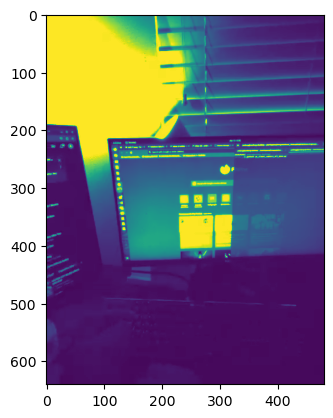

In [1166]:
plt.imshow(im_lf.T[:,::-1])

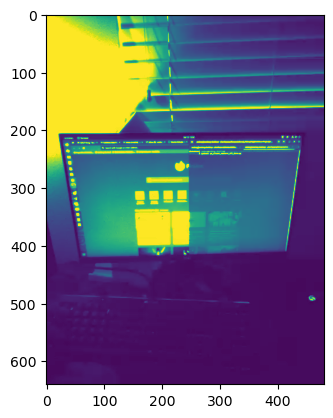

In [1167]:
plt.imshow(im_rf.T[::-1,:])

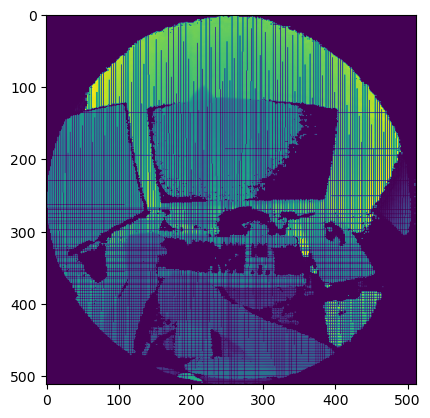

In [1168]:
#checking reprojection code .... :)
uv_ahat = get_uv(calib_ahat,calib_ahat,ahat_pts).astype(np.uint32)
new_ahat = np.zeros(im_ahat.shape)


new_ahat[uv_ahat[1,:],uv_ahat[0,:]] = ahat_pts[2,:]
plt.imshow(new_ahat)

Show 3d pts


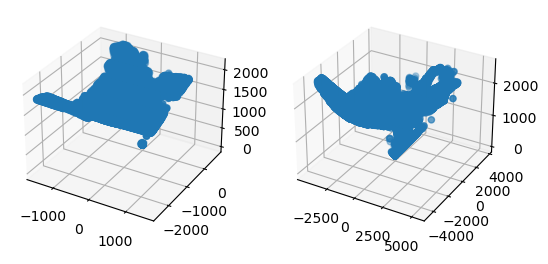

In [1169]:
print('Show 3d pts')

fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))
axs[0].scatter3D(pts_3d[0,:],pts_3d[1,:],pts_3d[2,:])
axs[1].scatter3D(ahat_pts[0,:],ahat_pts[1,:],ahat_pts[2,:])

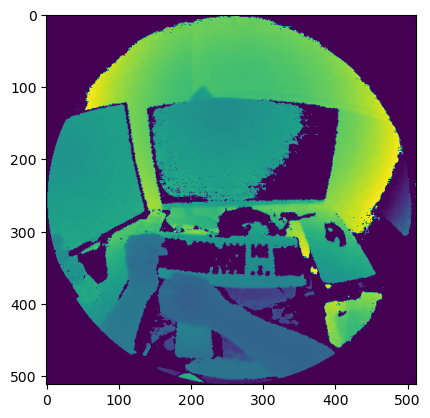

In [1170]:
plt.imshow(im_ahat/scale)

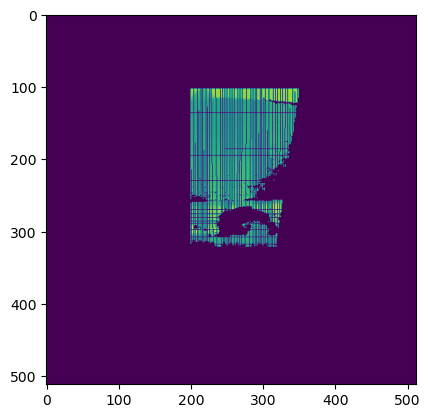

In [1171]:
uv_ahat = get_uv(calib_ahat,calib_ahat,pts_3d).astype(np.uint32)
new_ahat = np.zeros(im_ahat.shape)
new_ahat[uv_ahat[1,:],uv_ahat[0,:]] = pts_3d[2,:]

new_ahat[:,:200] = 0
plt.imshow(new_ahat)

In [1172]:
uv_lf = get_uv(calib_lf, calib_ahat, pts_3d).astype(np.uint32)
uv_rf = get_uv(calib_rf, calib_ahat, pts_3d).astype(np.uint32)

In [1173]:
new_im_lf = (im_lf.copy()) / im_lf.max() * 255
new_im_rf = im_rf.copy() / im_rf.max() * 255

lf_height, lf_width = im_lf.shape
rf_height, rf_width = im_rf.shape

lf_mask = ((uv_lf[0,:] < lf_width) & (uv_lf[0,:] > 0)) & ((uv_lf[1,:] < lf_height) & (uv_lf[1,:] > 0))
rf_mask = ((uv_rf[0,:] < rf_width) & (uv_rf[0,:] > 0)) & ((uv_rf[1,:] < rf_height) & (uv_rf[1,:] > 0))
mask = lf_mask & rf_mask

uv_lf = uv_lf[:,mask]
uv_rf = uv_rf[:,mask]
for i in range(uv_lf.shape[1]):
    new_im_lf = cv2.circle(new_im_lf, tuple(uv_lf[:,i]), 2, (255,0,0), -1)
    new_im_rf = cv2.circle(new_im_rf, tuple(uv_rf[:,i]), 2, (255,0,0), -1)

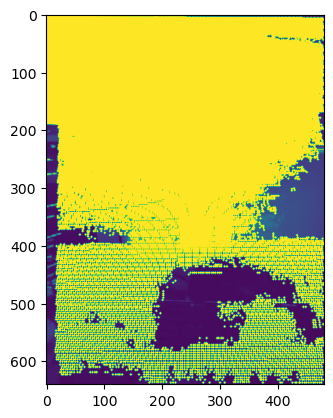

In [1174]:
plt.imshow(new_im_lf.T[:,::-1])

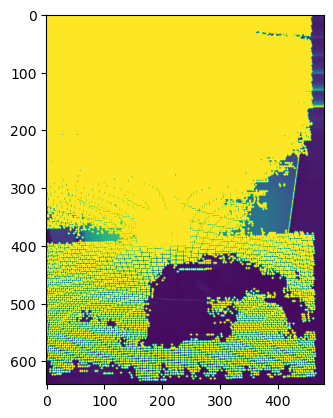

In [1175]:
plt.imshow(new_im_rf.T[::-1,:])

In [1176]:
uv_lf = get_uv(calib_lf, calib_ahat, ahat_pts).astype(np.uint32)
uv_rf = get_uv(calib_rf, calib_ahat, ahat_pts).astype(np.uint32)

new_im_lf = (im_lf.copy()) / im_lf.max() * 255
new_im_rf = im_rf.copy() / im_rf.max() * 255

lf_height, lf_width = im_lf.shape
rf_height, rf_width = im_rf.shape

lf_mask = ((uv_lf[0,:] < lf_width) & (uv_lf[0,:] > 0)) & ((uv_lf[1,:] < lf_height) & (uv_lf[1,:] > 0))
rf_mask = ((uv_rf[0,:] < rf_width) & (uv_rf[0,:] > 0)) & ((uv_rf[1,:] < rf_height) & (uv_rf[1,:] > 0))
mask = lf_mask & rf_mask

uv_lf = uv_lf[:,mask]
uv_rf = uv_rf[:,mask]
for i in range(uv_lf.shape[1]):
    new_im_lf = cv2.circle(new_im_lf, tuple(uv_lf[:,i]), 2, (255,0,0), -1)
    new_im_rf = cv2.circle(new_im_rf, tuple(uv_rf[:,i]), 2, (255,0,0), -1)

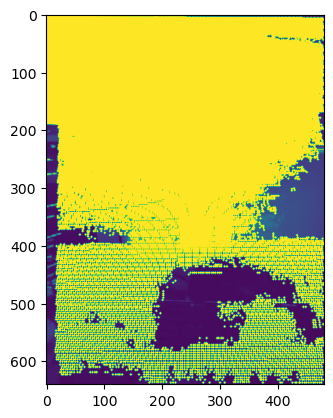

In [1177]:
plt.imshow(new_im_lf.T[:,::-1])

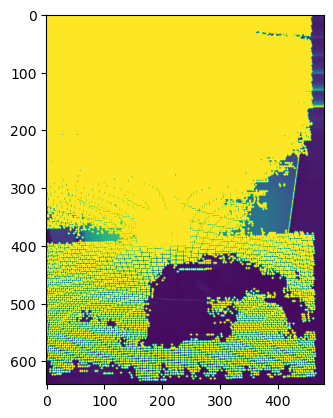

In [1178]:
plt.imshow(new_im_rf.T[::-1,:])

### Calibration Retrieve Code

### Problems I'm noticing
- room is too small for this to even matter (<1 meter distance)
- reprojection is off (something bad with calibration?)
    - try yunhan's data from gdrive?
    - could be something wrong with my hololens calibration
- not much of the depth data can be captured

- can't handle long distances unfortunately
- 